In [35]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import os
from matplotlib.colors import LinearSegmentedColormap
import re
from scipy import stats

cmap_greys = LinearSegmentedColormap.from_list("white_to_lightgrey", ["#ffffff", "#808080"])

curr_dir = os.getcwd()
Msn2T_df = pd.read_csv(os.path.join(curr_dir,'supp_tables/Table_S3_Msn2Tiling.csv'),index_col=0)
Msn2_mut_df = pd.read_csv(os.path.join(curr_dir,'supp_tables/Table_S4_Msn2mutations.csv'),index_col=0)

<font size="12">Functions</font>


In [28]:
def markDomains(tf,ax):
    domain_locs_df = pd.read_csv(os.path.join(curr_dir,'csv_files/tf_domains_plot.csv'),index_col =0).reset_index()
    domain_locs_df_sub = domain_locs_df[domain_locs_df['protein'].str.contains(tf)]    
    for index, row in domain_locs_df_sub.iterrows():
        ax.axvspan(int(row['start']), int(row['end']), facecolor=row['color'], alpha=0.3, label=row['domain'])
        ax.text(int(row['start'])+1, ax.get_ylim()[1]-0.1, row['domain'], fontsize = 8, color = row['color'])
        
def count_aa(sequence, aa_group):
    count = sum(sequence.count(aa) for aa in aa_group)
    return count

def count_all_groups(sequence, aa_groups):
    aa_counts = []
    for group in aa_groups:
        count = sum(sequence.count(aa) for aa in group)
        aa_counts.append(count)
    return pd.DataFrame({'aa_group': aa_groups, 'aa_counts' : aa_counts})

def get_wanted_subset(df,mut_type):
    mut_type_df = df.filter(regex=mut_type,axis=0).copy()
    func = lambda x: x.split('_')[3] 
    mut_type_df['cng_from'] = list(map(func,mut_type_df.index))
    func = lambda x: x.split('_')[4] 
    mut_type_df['cng_to'] = list(map(func,mut_type_df.index))
    
    group_dict = {'K':'KR','R':'KR','E':'ED','D':'ED','F':'FWY','W':'FWY','Y':'FWY','L':'LIVM','I':'LIVM','V':'LIVM','M':'LIVM',
              'N':'NQ','Q':'NQ','S':'ST','T':'ST','G':'GP','P':'GP','A':'A'}
    group_dict = {'K':'KR','R':'KR','E':'ED','D':'ED','F':'LIVMFWYA','W':'LIVMFWYA','Y':'LIVMFWYA','L':'LIVMFWYA','I':'LIVMFWYA',
                  'V':'LIVMFWYA','M':'LIVMFWYA','N':'STNQ','Q':'STNQ','S':'STNQ','T':'STNQ','G':'GP','P':'GP','A':'LIVMFWYA'}
    group_assign = lambda x: group_dict[x]
    mut_type_df['cng_to'] = mut_type_df['cng_to'].apply(group_assign).values
    return mut_type_df

def max_cluster_size(sequence,amino_acids):
    
    pattern = f"[{amino_acids}]+"
    matches = re.findall(pattern, sequence)
    
    if matches:
        return max(len(match) for match in matches)
    else:
        return 0

def cohen_d(x,y):
    nx = len(x)
    ny = len(y)
    dof = nx + ny - 2
    return (np.mean(x) - np.mean(y)) / np.sqrt(((nx-1)*np.std(x, ddof=1) ** 2 + (ny-1)*np.std(y, ddof=1) ** 2) / dof)


<font size="12">Plots</font>


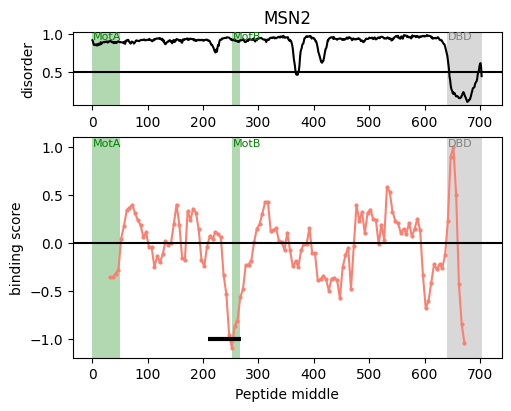

In [13]:
# plot distance from fit
window_size = 3
fig,axes = plt.subplots(2,1,figsize=(5,4),height_ratios=[1,3],constrained_layout = True)

#plot
temp_df = Msn2T_df[Msn2T_df['pep_type'] == 'tile']
dis_pred =  np.loadtxt(os.path.join(curr_dir,'metapredict_disorder_full_tfs/MSN2.txt'))
axes[0].plot(dis_pred,c='k')
markDomains('MSN2',axes[0])
axes[0].set_ylabel('disorder')
axes[0].set_title('MSN2')
axes[0].axhline(y=0.5,c='k')

y_value = pd.Series(temp_df['distanceFromFit']).rolling(window=window_size, min_periods=1).mean()
axes[1].plot(temp_df['pep_middle'],y_value,c='salmon',marker='o',markersize = 2)        
axes[1].axhline(y=0,c='k')
axes[1].set_ylabel('binding score')
markDomains('MSN2',axes[1])
axes[1].set_xlabel('Peptide middle')
axes[1].hlines(y=-1, xmin=209, xmax=269, color='k',linewidths = 3)



<Axes: xlabel='aa_group', ylabel='aa_counts'>

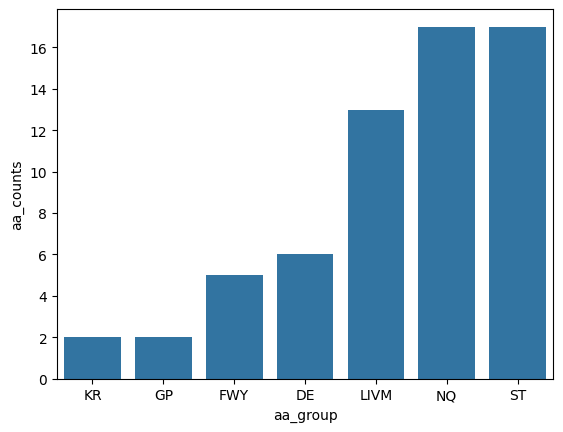

In [18]:
count_df = count_all_groups(Msn2_mut_df[Msn2_mut_df['pep_type']=='WT']['protein_seq'][0],['KR','DE','FWY','NQ','ST','LIVM','GP']).sort_values(by='aa_counts').set_index('aa_group')
sns.barplot(data = count_df,x=count_df.index,y='aa_counts')

0.20470334867788745

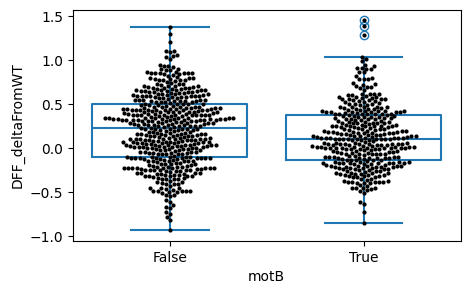

In [37]:
#MotB
motif = 'IDSMLDDYVSS'
Msn2_mut_df['motB'] = Msn2_mut_df['protein_seq'].apply(lambda x: motif in x).values

fig,ax=plt.subplots(figsize=(5,3))
sns.boxplot(data=Msn2_mut_df,y='DFF_deltaFromWT',x='motB',fill=False)
sns.swarmplot(data=Msn2_mut_df,y='DFF_deltaFromWT',x='motB',c='k',s=3)

t_stat, p_value = stats.ttest_ind(Msn2_mut_df[Msn2_mut_df['motB'] == 0]['DFF_deltaFromWT'], Msn2_mut_df[Msn2_mut_df['motB'] == 1]['DFF_deltaFromWT'])
cohen_d(Msn2_mut_df[Msn2_mut_df['motB'] == 0]['DFF_deltaFromWT'], Msn2_mut_df[Msn2_mut_df['motB'] == 1]['DFF_deltaFromWT'])

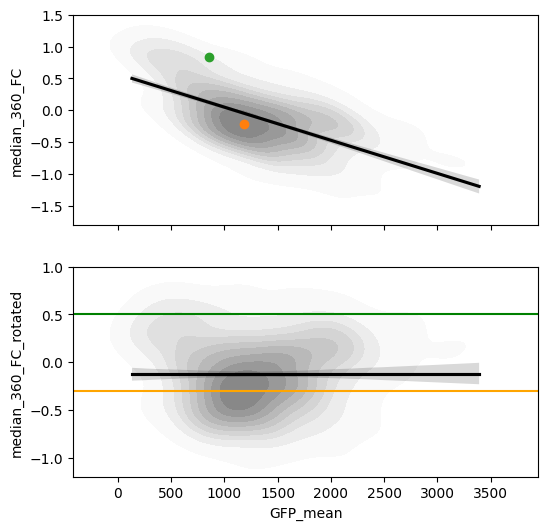

In [22]:
fig, ax = plt.subplots(2,1,figsize=(6,6),sharex=True)

sns.kdeplot(data = Msn2_mut_df,x = 'GFP_mean', y = 'median_360_FC',cmap=cmap_greys,fill=True,ax = ax[0])
sns.regplot(data=Msn2_mut_df, x="GFP_mean", y="median_360_FC",color='k',ax = ax[0],scatter=False)
ax[0].scatter(Msn2_mut_df[Msn2_mut_df['pep_type']=='WT']['GFP_mean'].mean(),Msn2_mut_df[Msn2_mut_df['pep_type']=='WT']['median_360_FC'].median())
ax[0].scatter(Msn2_mut_df[Msn2_mut_df['pep_type']=='control']['GFP_mean'].mean(),Msn2_mut_df[Msn2_mut_df['pep_type']=='control']['median_360_FC'].median())
ax[0].set_ylim([-1.8,1.5])
sns.kdeplot(data = Msn2_mut_df,x = 'GFP_mean', y = 'median_360_FC_rotated',cmap=cmap_greys,fill=True,ax = ax[1])
sns.regplot(data=Msn2_mut_df, x="GFP_mean", y="median_360_FC_rotated",color='k',ax = ax[1],scatter=False)
ax[1].axhline(Msn2_mut_df[Msn2_mut_df['pep_type']=='WT']['median_360_FC_rotated'].median(),c='orange')
ax[1].axhline(Msn2_mut_df[Msn2_mut_df['pep_type']=='control']['median_360_FC_rotated'].median(),c='green')

ax[1].set_ylim([-1.2,1])

plt.show()

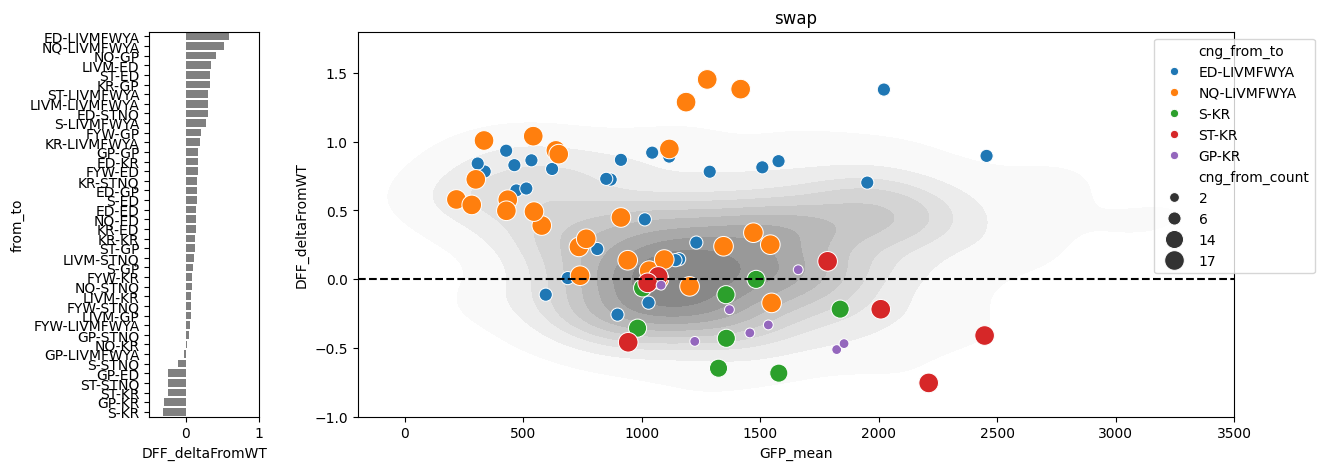

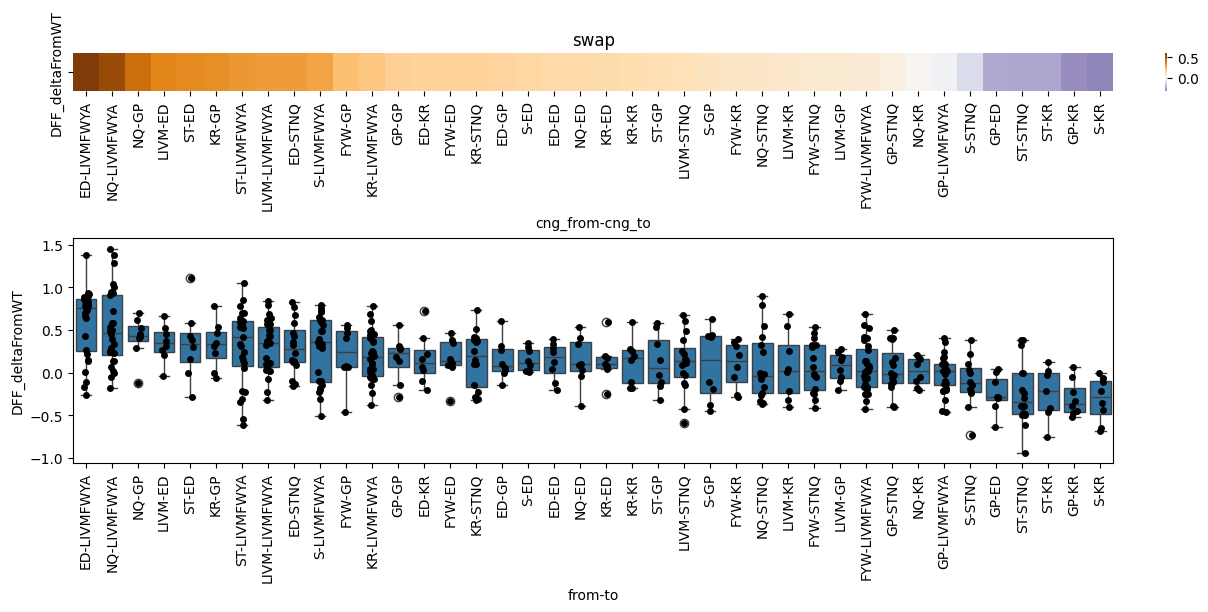

In [25]:
#swap!

swap_df = Msn2_mut_df.filter(regex='swap',axis=0)
swap_df = get_wanted_subset(swap_df,'swap')

swap_df['cng_from_count'] = swap_df.apply(lambda row: count_aa(Msn2_mut_df.filter(regex='wt',axis=0)["protein_seq"][0], row['cng_from']), axis=1)
swap_df['cng_from_to'] = swap_df['cng_from'] + '-'+swap_df['cng_to']

mean_swap_df = pd.DataFrame(swap_df.groupby(['cng_from','cng_to'])['DFF_deltaFromWT'].mean().sort_values(ascending=False)).T
temp = mean_swap_df.T.reset_index()
temp['from_to'] = temp['cng_from'] +'-'+ temp['cng_to']

fig,ax = plt.subplots(1,2,figsize=(14,5),width_ratios=[1,8])
sns.barplot(data=temp,y='from_to',x='DFF_deltaFromWT',ax=ax[0],color='grey')
ax[0].set_xlim(-0.5,1)
    
filtered_df = swap_df[swap_df['cng_from_to'].str.contains('S-KR|ST-KR|GP-KR|NQ-LIVMFWYA|ED-LIVMFWYA')]
sns.kdeplot(data = Msn2_mut_df,x = 'GFP_mean', y = 'DFF_deltaFromWT',cmap=cmap_greys,fill=True,ax=ax[1])
sns.scatterplot(data = filtered_df,x='GFP_mean',y='DFF_deltaFromWT',hue = 'cng_from_to',size='cng_from_count',sizes=(50,200),ax=ax[1])
ax[1].axhline(y=0,c='k',linestyle='--')
ax[1].set_title('swap')
plt.xlim(-200,3500)
plt.ylim(-1,1.8)
plt.legend(bbox_to_anchor=(1.1,1))


#supp
fig,ax = plt.subplots(2,1,figsize=(12,6),layout='constrained',height_ratios=[1,6])
sns.heatmap(mean_swap_df,cmap='PuOr_r',center=0,ax=ax[0])

temp_df = swap_df.loc[:,['cng_from','cng_to','DFF_deltaFromWT']].reset_index().drop(columns=['Seq_name'])
temp_df['from-to'] = temp_df['cng_from'] + '-'+temp_df['cng_to']
sort_order = mean_swap_df.T.reset_index()['cng_from']+'-'+mean_swap_df.T.reset_index()['cng_to']
sns.boxplot(data=temp_df,x='from-to',y='DFF_deltaFromWT',order=sort_order.values,ax=ax[1])
sns.stripplot(data=temp_df,x='from-to',y='DFF_deltaFromWT',order=sort_order.values,c='k',ax=ax[1])

plt.xticks(rotation=90)
ax[0].set_title('swap')
plt.show()


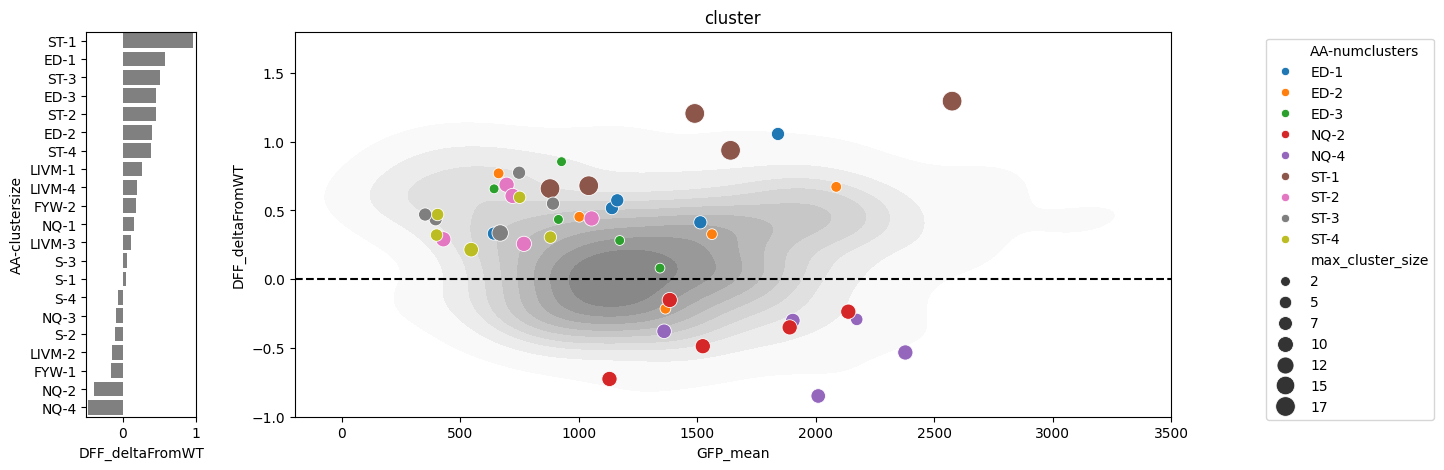

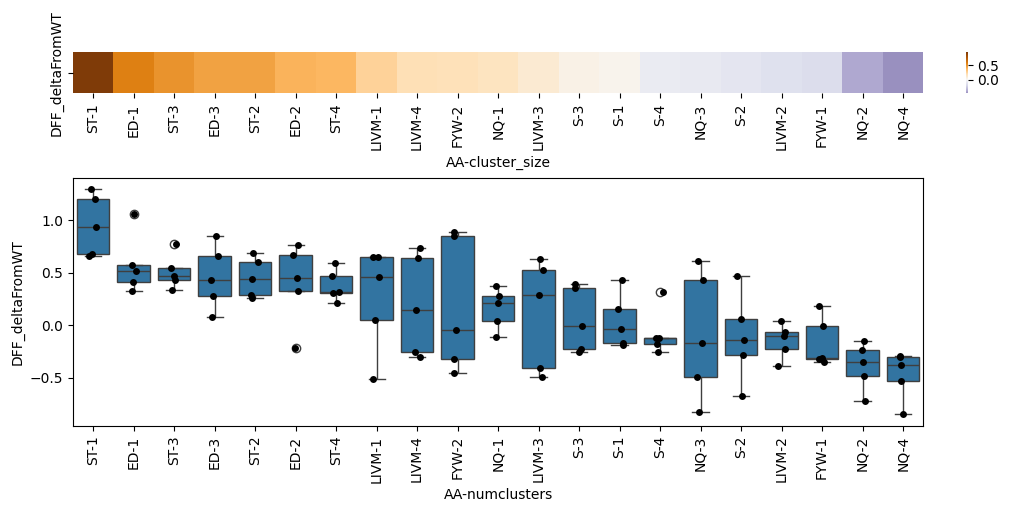

In [31]:
#Cluster!

cluster_df = Msn2_mut_df.filter(regex='cluster',axis=0).copy()
cluster_df['AA'] = cluster_df.index.str.split('_').str[2]
cluster_df['cluster_size'] = cluster_df.index.str.split('_').str[1].str[0]
cluster_df['AA-numclusters'] = cluster_df['AA'] + '-'+cluster_df['cluster_size']
cluster_df['max_cluster_size'] = cluster_df.apply(lambda row: max_cluster_size(row['protein_seq'], row['AA']),axis=1)
mean_cluster_df = pd.DataFrame(cluster_df.groupby(['AA','cluster_size'])['DFF_deltaFromWT'].mean().sort_values(ascending=False)).T
temp = mean_cluster_df.T.reset_index()
temp['AA-clustersize'] = temp['AA'] +'-'+ temp['cluster_size']
filtered_df = cluster_df[cluster_df['AA-numclusters'].str.contains('NQ-4|NQ-2|ST-4|ED-2|ST-2|ED-3|ST-3|ED-1|ST-1')]

fig,ax = plt.subplots(1,2,figsize=(14,5),width_ratios=[1,8])
sns.barplot(data=temp,y='AA-clustersize',x='DFF_deltaFromWT',ax=ax[0],color='grey')
ax[0].set_xlim(-0.5,1)

sns.kdeplot(data = Msn2_mut_df,x = 'GFP_mean', y = 'DFF_deltaFromWT',cmap=cmap_greys,fill=True,ax=ax[1])
sns.scatterplot(data = filtered_df,x='GFP_mean',y='DFF_deltaFromWT',hue = 'AA-numclusters',ax=ax[1],size='max_cluster_size',sizes=(50,200))
ax[1].axhline(y=0,c='k',linestyle='--')
ax[1].set_title('cluster')
ax[1].set_xlim(-200,3500)
ax[1].set_ylim(-1,1.8)
plt.legend(bbox_to_anchor=(1.1,1))

#supp
temp_df = cluster_df.loc[:,['AA','DFF_deltaFromWT','AA-numclusters']].reset_index().drop(columns=['Seq_name'])
sort_order = mean_cluster_df.T.reset_index()['AA']+'-'+mean_cluster_df.T.reset_index()['cluster_size']

fig,ax = plt.subplots(2,1,figsize=(10,5),layout='constrained',height_ratios=[1,6])
sns.heatmap(mean_cluster_df,cmap='PuOr_r',center=0,ax=ax[0])
sns.boxplot(data=temp_df,x='AA-numclusters',y='DFF_deltaFromWT',order=sort_order.values,ax=ax[1])
sns.stripplot(data=temp_df,x='AA-numclusters',y='DFF_deltaFromWT',order=sort_order.values,c='k',ax=ax[1])
plt.xticks(rotation=90)
plt.show()




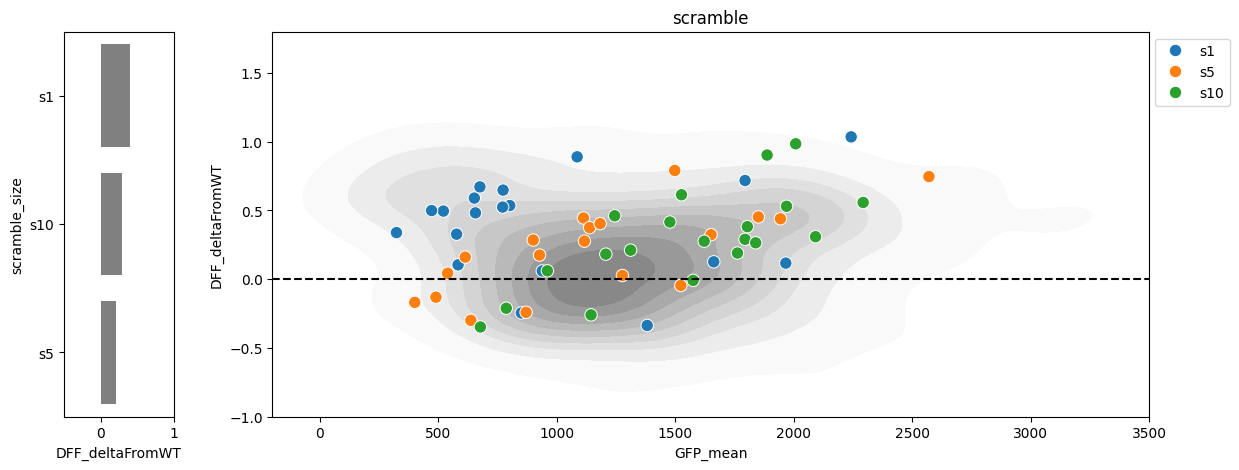

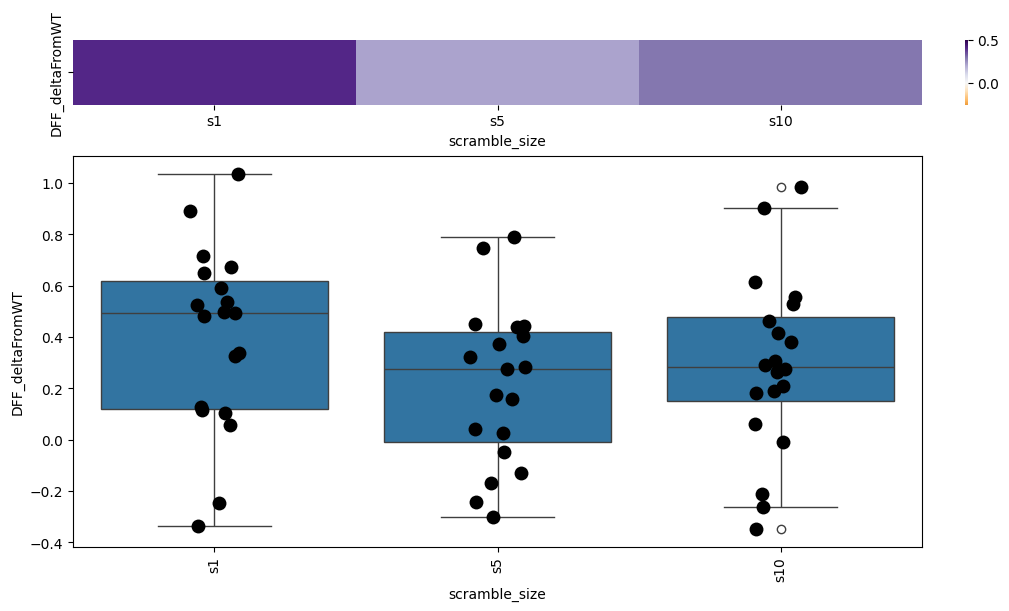

In [32]:
#scarmble

fig,ax = plt.subplots(1,2,figsize=(14,5),width_ratios=[1,8])
scramble_df = Msn2_mut_df.filter(regex='scramble',axis=0).copy()
scramble_df['scramble_size'] = scramble_df.index.str.split('_').str[2]
mean_df = pd.DataFrame(scramble_df.groupby(['scramble_size'])['DFF_deltaFromWT'].mean().sort_values(ascending=False)).T
sns.barplot(data=mean_df.T.reset_index(),x='DFF_deltaFromWT',y='scramble_size',ax=ax[0],color='grey')
ax[0].set_xlim(-0.5,1)

sns.kdeplot(data = Msn2_mut_df,x = 'GFP_mean', y = 'DFF_deltaFromWT',cmap=cmap_greys,fill=True,ax=ax[1])
sns.scatterplot(data = scramble_df,x='GFP_mean',y='DFF_deltaFromWT',hue = 'scramble_size',ax=ax[1],s=80)
ax[1].axhline(y=0,c='k',ls='--')
ax[1].set_xlim(-200,3500)
ax[1].set_ylim(-1,1.8)
ax[1].set_title('scramble')
plt.legend(bbox_to_anchor=(1.1,1))

#supp
fig,ax = plt.subplots(2,1,figsize=(10,6),layout='constrained',height_ratios=[1,6])
sns.heatmap(mean_df.loc[:,['s1','s5','s10']],cmap='PuOr',center=0,vmin=-0.25,vmax=0.5,ax=ax[0])
sns.boxplot(data=scramble_df,x='scramble_size',y='DFF_deltaFromWT',order=['s1','s5','s10'],ax=ax[1])
sns.stripplot(data=scramble_df,x='scramble_size',y='DFF_deltaFromWT',order=['s1','s5','s10'],c='k',ax=ax[1],s=10)

plt.xticks(rotation=90)
plt.show()


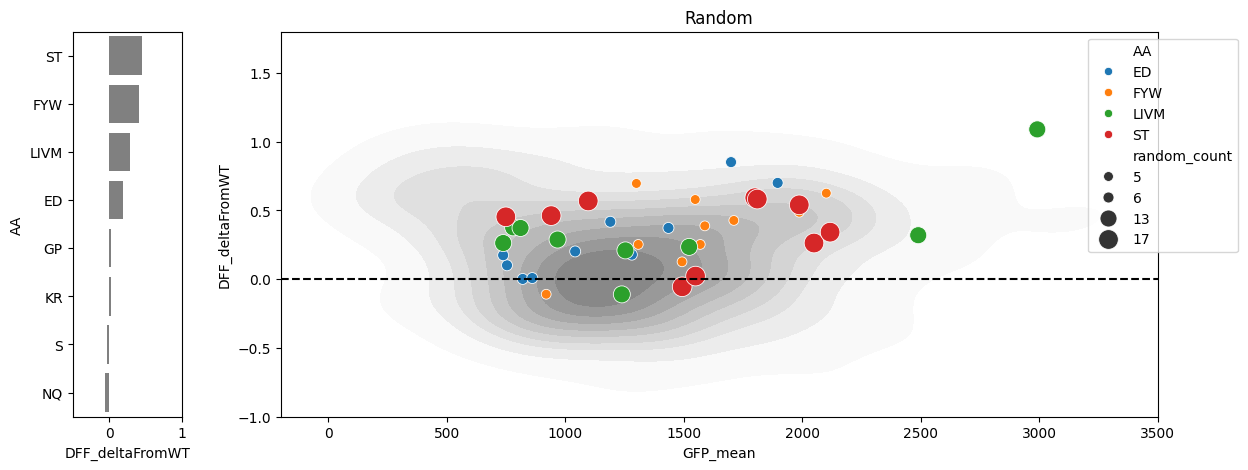

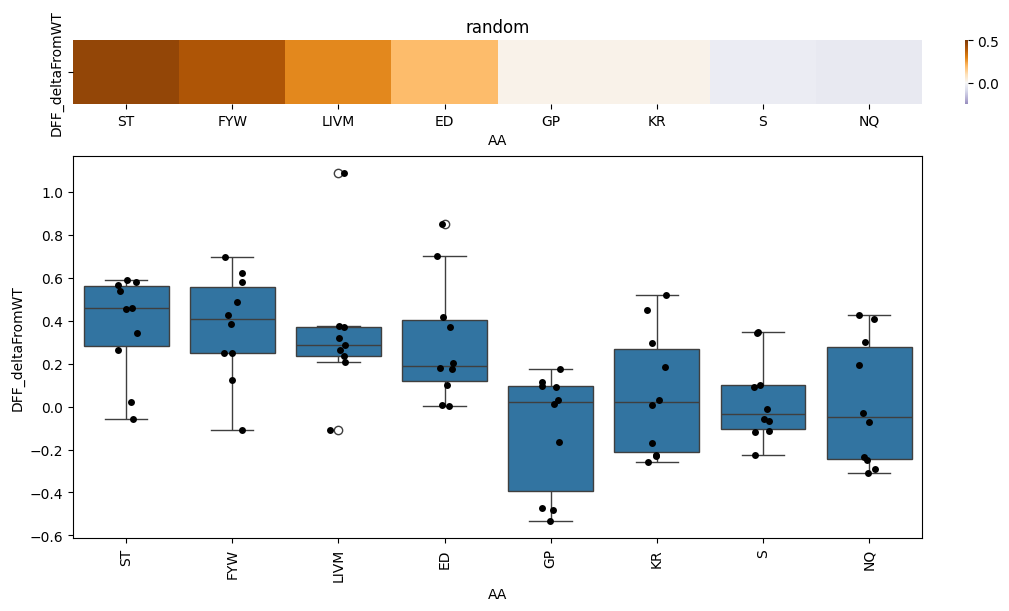

In [33]:
#Random
fig,ax = plt.subplots(1,2,figsize=(14,5),width_ratios=[1,8])
random_df = Msn2_mut_df.filter(regex='random',axis=0).copy()
random_df['AA'] = random_df.index.str.split('_').str[2]
random_df['random_count'] = random_df.apply(lambda row: count_aa(Msn2_mut_df.filter(regex='wt',axis=0)["protein_seq"][0], row['AA']), axis=1)
mean_df = pd.DataFrame(random_df.groupby(['AA'])['DFF_deltaFromWT'].median().sort_values(ascending=False)).T


#bar of mean effect of group
sns.barplot(data=mean_df.T.reset_index(),x='DFF_deltaFromWT',y='AA',ax=ax[0],color='grey')
ax[0].set_xlim(-0.5,1)

#scatter in the cloud
sns.kdeplot(data = Msn2_mut_df,x = 'GFP_mean', y = 'DFF_deltaFromWT',cmap=cmap_greys,fill=True,ax=ax[1])
sns.scatterplot(data = random_df[random_df['AA'].str.contains('ED|LIVM|FYW|ST')],x='GFP_mean',y='DFF_deltaFromWT',hue = 'AA',size='random_count',ax=ax[1],sizes=(50,200))
ax[1].axhline(y=0,c='k',ls='--')
ax[1].set_title('Random')
ax[1].set_xlim(-200,3500)
ax[1].set_ylim(-1,1.8)
plt.legend(bbox_to_anchor=(1.1,1))
# plt.savefig("/home/labs/barkailab/offirlu/pepLib/Paper/Fig5/Random.pdf", format="pdf", bbox_inches="tight")


#supp
fig,ax = plt.subplots(2,1,figsize=(10,6),layout='constrained',height_ratios=[1,6])
sns.heatmap(mean_df,cmap='PuOr_r',center=0,vmin=-0.25,vmax=0.5,ax=ax[0])
sns.boxplot(data=random_df,x='AA',y='DFF_deltaFromWT',order=mean_df.columns,ax=ax[1])
sns.stripplot(data=random_df,x='AA',y='DFF_deltaFromWT',order=mean_df.columns,c='k',ax=ax[1])

plt.xticks(rotation=90)
ax[0].set_title('random')
plt.show()